In [225]:
import sys
import numpy as np
import pandas as pd

In [226]:
from real_estate.models.random_variables import *
from real_estate.models import ExpenseModel, MonteCarloSimulator, RevenueModel, TaxBenefitModel

# Revenue & Tax Benefit Models

In [227]:
N_YEARS: int = 30
N_SIMULATIONS: int = 10_000
N_PAYMENTS_PER_YEAR: int = 12
N_PERIODS: int = N_YEARS * N_PAYMENTS_PER_YEAR
DISCOUNT_RATE: float = 0.02 / N_PAYMENTS_PER_YEAR
INTEREST_RATE: float = 0.065 / N_PAYMENTS_PER_YEAR

RENT: float = 3_000.0
LAND_VALUE: float = 0.0
PROPERTY_VALUE: float = 350_000.0
DOWN_PAYMENT_PERCENTAGE: float = 0.20
TOTAL_VALUE: float = LAND_VALUE + PROPERTY_VALUE

EQUITY: float = TOTAL_VALUE * DOWN_PAYMENT_PERCENTAGE 
DEBT: float = TOTAL_VALUE - EQUITY

OCCUPANCY_RATE_PROBABILITY: float = 10 / 12
OCCUPANCY_RATE: RandomVariable = IndicatorRandomVariable(probability=OCCUPANCY_RATE_PROBABILITY)

In [228]:
REVENUE_MODEL: RevenueModel = RevenueModel(rent=RENT, occupancy_rate=OCCUPANCY_RATE)
TAX_BENEFIT_MODEL: TaxBenefitModel = TaxBenefitModel(n=N_PERIODS, property_value=PROPERTY_VALUE)

# Expense Model

In [229]:
PERCENT_TAX_EXPENSE: float = 0.02 / N_PAYMENTS_PER_YEAR
TAX_EXPENSE_MU: float = PERCENT_TAX_EXPENSE * TOTAL_VALUE
TAX_EXPENSE: RandomVariable = NormalRandomVariable(mu=TAX_EXPENSE_MU)

UTILITY_EXPENSE_MU: float = 100.0
UTILITY_EXPENSE_SIGMA: float = 20.0
UTILITY_EXPENSE_LOWER_BOUND: float = 50.0
UTILITY_EXPENSE_UPPER_BOUND: float = 200.0
UTILITY_EXPENSE: RandomVariable = BoundedNormalRandomVariable(
    mu=UTILITY_EXPENSE_MU, 
    sigma=UTILITY_EXPENSE_SIGMA, 
    lower_bound=UTILITY_EXPENSE_LOWER_BOUND, 
    upper_bound=UTILITY_EXPENSE_UPPER_BOUND
)

INSURACE_EXPENSE_MU: float = 100.0
INSURACE_EXPENSE_SIGMA: float = 20.0
INSURANCE_EXPENSE_LOWER_BOUND: float = 20.0
INSURANCE_EXPENSE_UPPER_BOUND: float = 200.0
INSURACE_EXPENSE: RandomVariable = BoundedNormalRandomVariable(
    mu=INSURACE_EXPENSE_MU, 
    sigma=INSURACE_EXPENSE_SIGMA, 
    lower_bound=INSURANCE_EXPENSE_LOWER_BOUND, 
    upper_bound=INSURANCE_EXPENSE_UPPER_BOUND
)

MAINTENANCE_EXPENSE_MU: float = 100.0
MAINTENANCE_EXPENSE_SIGMA: float = 20.0
MAINTENANCE_EXPENSE_LOWER_BOUND: float = 20.0
MAINTENANCE_EXPENSE_UPPER_BOUND: float = 200.0
MAINTENANCE_EXPENSE: RandomVariable = BoundedNormalRandomVariable(
    mu=MAINTENANCE_EXPENSE_MU, 
    sigma=MAINTENANCE_EXPENSE_SIGMA, 
    lower_bound=MAINTENANCE_EXPENSE_LOWER_BOUND, 
    upper_bound=MAINTENANCE_EXPENSE_UPPER_BOUND
)

MISCELLANEOUS_EXPENSE_MU: float = 0.0
MISCELLANEOUS_EXPENSE_SIGMA: Optional[float] = 1000.0
MISCELLANEOUS_EXPENSE: RandomVariable = BoundedNormalRandomVariable(
    mu=MISCELLANEOUS_EXPENSE_MU, 
    sigma=MISCELLANEOUS_EXPENSE_SIGMA, 
    lower_bound=0.0, 
    upper_bound=2000.0
)

In [230]:
EXPENSE_MODEL: ExpenseModel = ExpenseModel(
    tax_expense=TAX_EXPENSE,
    utility_expense=UTILITY_EXPENSE,
    insurance_expense=INSURACE_EXPENSE, 
    maintenance_expense=MAINTENANCE_EXPENSE,
    miscellaneous_expense=MISCELLANEOUS_EXPENSE 
)

In [231]:
simulation = MonteCarloSimulator(
    debt=DEBT,
    rate=INTEREST_RATE, 
    equity=EQUITY,
    expense_model=EXPENSE_MODEL,
    revenue_model=REVENUE_MODEL,
    tax_benefit_model=TAX_BENEFIT_MODEL,
    n_periods=N_PERIODS,
    n_simulations=N_SIMULATIONS
)

In [232]:
simulation.run()

In [233]:
simulation.total_cagr.median()

0.0799085453905134

<Axes: >

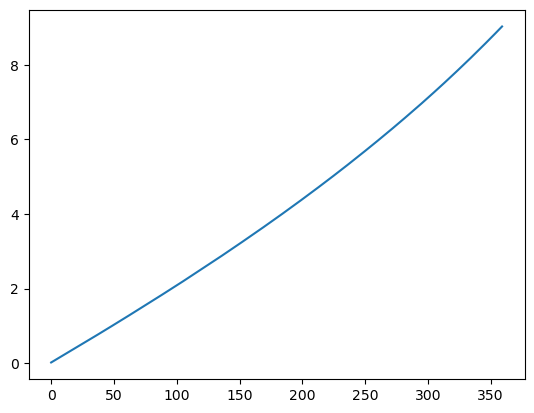

In [234]:
simulation.cumulative_total_return_on_initial_equity.mean(axis=1).plot()

In [235]:
x = {}
for i, cash_flow_series in simulation.cash_flow_simulation.items():
    x[i] = {}
    for j, cash_flow in cash_flow_series.items(): 
        if j != 0:
            x[i][j] = (cash_flow + x[i][j-1]) * (1 + 0.05 / 12)
        else:
            x[i][j] = cash_flow * (1 + 0.05 / 12)

(<Axes: >, 0.09964177555528131)

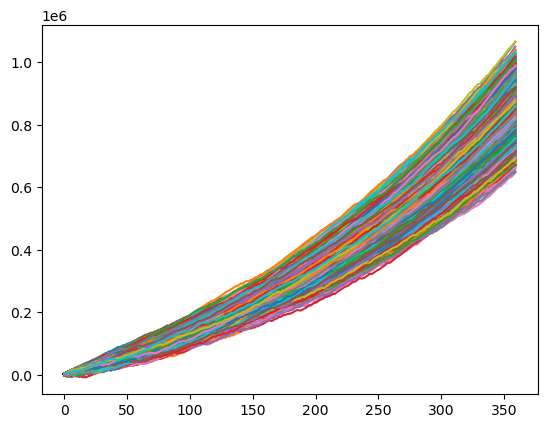

In [236]:
pd.DataFrame(x).plot(legend=False),
((1 + (pd.DataFrame(x).iloc[-1] + DEBT) / EQUITY) ** (1 / 30) - 1).median()

Terminal Cash Flow Mean: 325724.2519559512
Terminal Cash Flow Min: 236826.6419136681
Terminal Cash Flow Max: 405917.36045064736
Periodic Cash Flow Mean: 904.7895887665311
Periodic Cash Flow Standard Deviation: 1234.7052498834896
Cash Flow Mean Annualized Sharpe Ratio: 2.5384868786309323


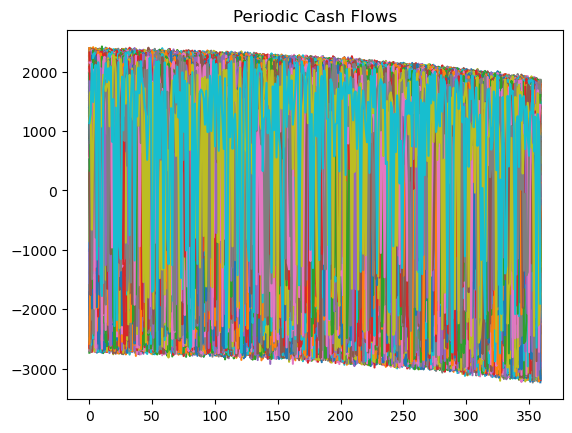

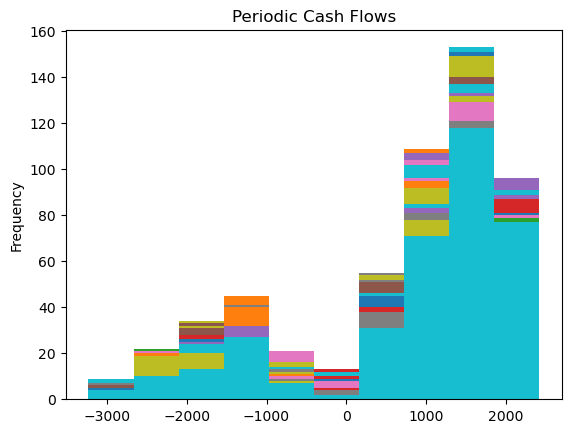

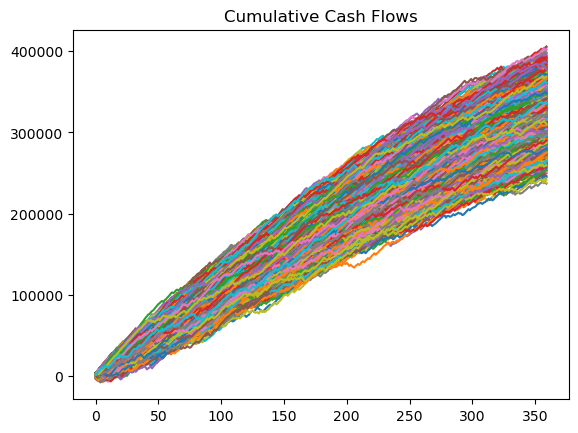

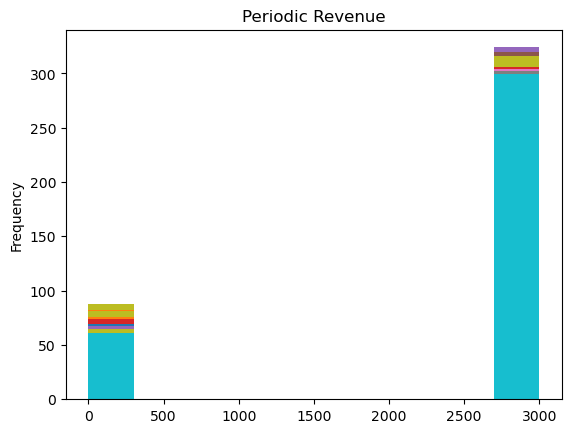

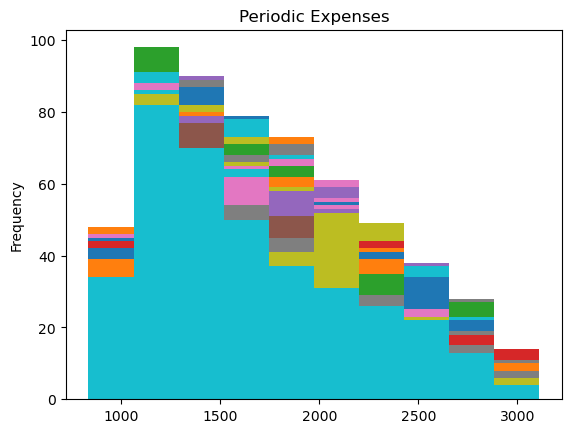

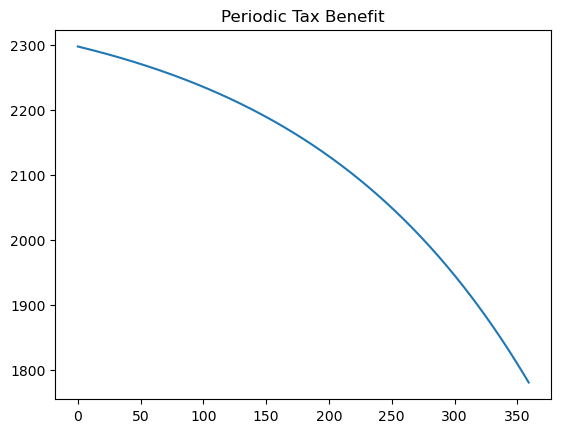

In [21]:
simulation.analyze()

<Axes: ylabel='Frequency'>

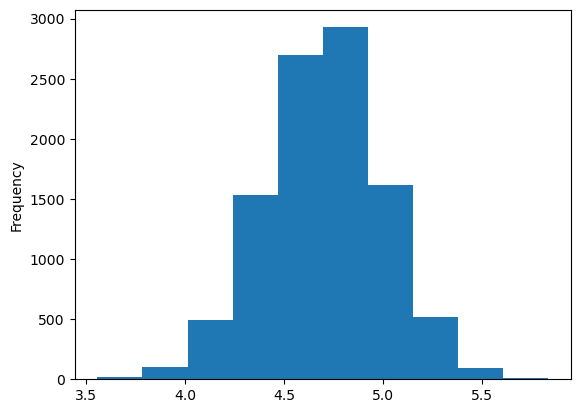

In [18]:
simulation.cumulative_total_return_on_initial_equity.iloc[-1].plot(kind="hist")

<Axes: >

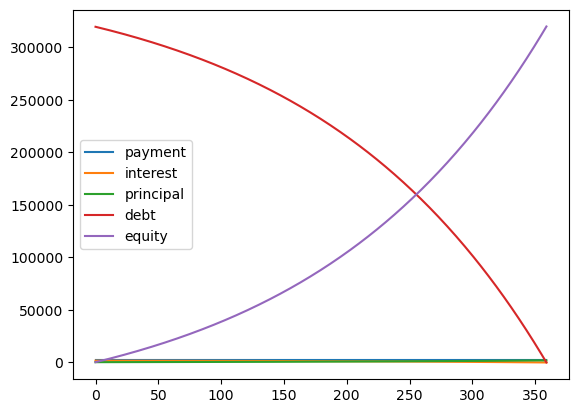

In [203]:
simulation.ammortization_schedule.schedule.plot()

# Build DCF to compute a fair value

In [237]:
long_term_growth_rate = 0.10
terminal_value = simulation.cash_flow_simulation.iloc[-1].median() / (long_term_growth_rate / N_PAYMENTS_PER_YEAR)
terminal_value

133252.96946389508

In [238]:
discount_factor = {}

for n in range(N_PERIODS):
    discount_factor[n] = 1 / (1 + DISCOUNT_RATE) ** n

discount_factor = pd.Series(discount_factor)
discount_factor

0      1.000000
1      0.998336
2      0.996675
3      0.995017
4      0.993361
         ...   
355    0.553677
356    0.552756
357    0.551836
358    0.550918
359    0.550001
Length: 360, dtype: float64

In [239]:
pv_terminal_value = terminal_value * discount_factor.iloc[-1]
pv_terminal_value

73289.25964458977

<Axes: ylabel='Frequency'>

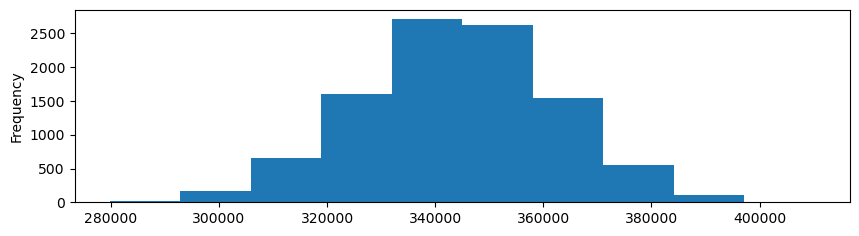

In [240]:
(
    pv_terminal_value 
    + pd.Series(
        np.sum(
            np.multiply(
                np.array(simulation.cash_flow_simulation),
                np.reshape(np.array(discount_factor), newshape=(-1, 1))
            ),
            axis=0
        )
    )
).plot(kind="hist", figsize=(10, 2.5))

<Axes: ylabel='Frequency'>

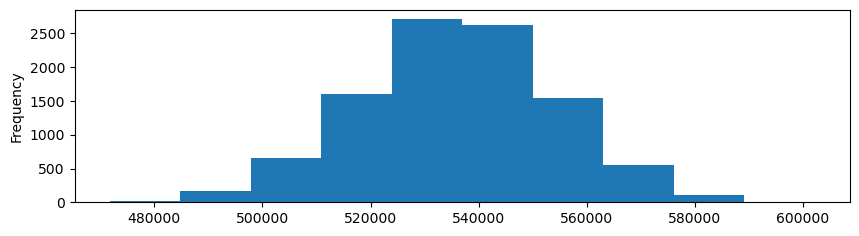

In [241]:
(
    pv_terminal_value 
    + pd.Series(
        np.sum(
            np.multiply(
                np.add(
                    np.array(simulation.cash_flow_simulation),
                    np.reshape(np.array(simulation.ammortization_schedule.schedule["principal"]), newshape=(-1, 1))
                ),
                np.reshape(np.array(discount_factor), newshape=(-1, 1))
            ),
            axis=0
        )
    )
).plot(kind="hist", figsize=(10, 2.5))

In [242]:
simulation.cash_flow_simulation

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1646.551840,925.546380,989.179440,2263.547432,1617.403153,1602.010165,1465.231712,2036.034592,862.636565,853.395612,...,1409.051500,1113.965615,2072.030768,-2221.521103,-1332.267303,1344.678898,1141.303897,2224.395834,2068.195025,1869.101584
1,1668.376739,720.934563,1764.076157,2080.650800,1906.254277,2051.594751,2152.041663,-1046.610955,507.113641,1692.496586,...,1287.738041,1969.365879,-1163.339067,1558.779337,1864.797920,1716.724934,-846.762035,2057.154309,2311.213314,1010.381802
2,-930.032849,953.755745,458.000097,-987.769995,1807.398892,1417.847850,1180.007512,1226.294543,1002.589112,2072.484798,...,1479.812743,-988.623585,1771.622122,1838.177400,1838.261422,524.996956,623.041091,2253.396132,1279.558893,2374.254488
3,2181.191244,1354.438541,1210.890554,1367.496250,-1146.141807,748.028473,2247.430589,1389.397974,1621.452872,-2497.877021,...,2227.825741,1714.856793,-2116.056347,2140.681395,-789.846447,917.679188,1418.617109,2237.229848,2257.525485,2233.263661
4,1990.383944,1744.515604,1342.760375,1895.318134,1432.215534,1570.546855,1021.225683,2257.422886,1674.338910,1776.658600,...,1686.268350,1420.479490,1887.852415,1298.347643,1927.635305,-1527.628925,2102.036873,558.706418,1943.345349,-1879.214498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,482.106998,-1504.417262,1167.480304,1034.760260,-1578.744031,660.891955,1014.753580,1409.342307,668.289800,-50.322569,...,537.888717,-1559.561808,-1609.184484,623.855354,1357.547357,-2963.317098,-1916.036016,1035.082160,1624.991824,28.375869
356,1061.180264,1474.228607,677.234694,1779.582158,1812.182543,1645.327722,643.235309,1299.489870,739.733376,1863.745922,...,1895.690193,1324.587470,1278.742888,1591.667832,851.456801,1901.307702,1298.033596,1645.681487,1443.915872,419.075445
357,1869.776415,430.875634,237.007867,1460.527609,761.904122,1256.487319,-2092.429115,1681.531327,-2459.512710,1413.723173,...,-2309.786065,683.214909,1321.691447,1422.536024,1612.587840,1456.282354,-2989.521983,625.919646,1305.901514,556.602162
358,477.776490,624.867325,783.402985,1855.977065,797.483745,1625.953272,844.911983,268.200704,694.427524,1748.303620,...,611.770580,1239.333904,825.127097,1462.016079,-1396.108492,-1701.227560,1379.369918,958.850537,263.398141,1755.781471


In [167]:
simulation.ammortization_schedule.schedule["principal"] + simulation.cash_flow_simulation

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-1389.707809,3210.412131,3182.501413,-792.953302,3257.826968,2949.928749,2923.056028,2847.615960,3085.898489,3221.381661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2166.324681,3565.913105,2311.808340,3001.652312,2305.918586,2702.683534,-882.795661,-954.109911,1769.007570,-2157.388585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3344.359060,2600.803135,2627.185118,-2073.897055,2897.460998,3556.304456,3084.019880,3247.746526,2470.561297,3440.568168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3255.359045,3101.525620,2834.779427,3350.421081,3228.149906,3502.976243,3539.520050,2942.047824,2035.916823,-1658.305187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2853.395934,1951.957641,3124.842749,2268.864291,2447.193976,2551.985483,-1471.420739,3389.738387,2971.712401,3174.951583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,3067.466759,-2298.289825,2153.919544,-973.511518,1839.344196,2698.915829,1675.033982,2401.034880,2961.060700,3087.903246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,2295.292179,2940.021657,3037.077541,2766.759671,1200.881428,2256.634416,2736.601126,2515.657160,3026.475764,-1143.329567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,3076.188280,-1354.355675,-1382.796611,2460.457557,2482.638788,2849.257250,2528.551186,2101.565050,3044.206703,2968.622789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,2684.529100,2474.338963,2877.548957,2827.662538,-1766.730170,2534.642226,2867.217113,2711.075756,1589.600561,2951.439771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
